In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import scipy as sp
from scipy import signal

In [ ]:
def preparo(ds,y_certo,passo=.5,duracao=1,Fs=500):
  qtd_seq = ds.shape[0]//(Fs*duracao*passo)
  intersec = Fs*(duracao-passo)
  dados_final = np.zeros((int(qtd_seq),int(duracao*Fs),6*ds.shape[1]))
  y_final = np.zeros((int(qtd_seq),int(duracao*Fs)))
  for n_seq in range(int(qtd_seq)):
    pos = n_seq*intersec
    seq = ds[pos:pos+duracao*Fs,:]
    delta = filtragem(seq,f_pa=2,f_pb=4)
    theta = filtragem(seq,f_pa=4,f_pb=8)
    alfa = filtragem(seq,f_pa=8,f_pb=12)
    beta = filtragem(seq,f_pa=12,f_pb=30)
    gamma = filtragem(seq,f_pa=30)
    dados_final[i,:,:] = np.concatenate((seq,delta,theta,alfa,beta,gamma),axis=1)
    y_final[i,:] = y_certo[pos:pos+duracao*Fs]
    
  return dados_final, y_final

In [ ]:
train = pd.read_csv('Train.csv',delimiter=';')
val = pd.read_csv('Validation.csv',delimiter=';')
test = pd.read_csv('Test.csv',delimiter=';')

eliminar = train.columns[-3]

train = train.drop(columns=eliminar)
val = val.drop(columns=eliminar)
test = test.drop(columns=eliminar)

In [ ]:
features = train.columns[:-1]

train = train.to_numpy()
val = val.to_numpy()
test = test.to_numpy()

In [ ]:
x_train, y_train = train[:,:-1], train[:,-1:]
x_val, y_val = val[:,:-1], val[:,-1:]
x_test, y_test = test[:,:-1], test[:,-1:]

In [ ]:
x_train, y_train = preparo(x_train,y_train)
x_val, y_val = preparo(x_val,y_val)
x_test, y_test = preparo(x_test,y_test)

In [ ]:
train_mean = x_train.mean(axis=0)
train_std = x_train.std(axis=0)

x_train = (x_train - train_mean)/train_std
x_val = (x_val - train_mean)/train_std
x_test = (x_test - train_mean)/train_std

In [ ]:
stride = 500
batch = 1
train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=stride,sequence_stride = int(stride/2),
    sampling_rate=1,shuffle=True,batch_size = batch, seed=42)

val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val, y_val, sequence_length=stride,sequence_stride = int(stride/2),
    sampling_rate=1,shuffle=True,batch_size = batch, seed=42)

test = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test, y_test, sequence_length=stride,sequence_stride = int(stride/2),
    sampling_rate=1,shuffle=True,batch_size = batch, seed=42)

In [ ]:
stride = 500
# sig = layers.Input((stride,len(features)))
input = layers.Input((stride,19))

In [ ]:
m1 = layers.Conv1D(32,5,strides=1,activation='relu',padding='same', kernel_regularizer='l2')(input)
m1 = layers.BatchNormalization()(m1)
m1 = layers.Conv1D(16,3,strides=1,activation='relu',padding='same', kernel_regularizer='l2')(m1)
m1 = layers.Flatten()(m1)
m1 = layers.Dense(32,activation='relu')(m1)
m1 = layers.Dropout(.2)(m1)
m1 = layers.Dense(8,activation='relu')(m1)
m1 = layers.Dense(2,activation='sigmoid')(m1)

model1= tf.keras.Model(inputs=input,outputs=m1)

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 19)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           3072      
                                                                 
 batch_normalization (BatchN  (None, 500, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, 500, 16)           1552      
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                                 
 dense (Dense)               (None, 32)                256032    
                                                             

In [ ]:
via1 = layers.Conv1D(128,7,strides=1,activation='relu',padding='same')(input)
via1 = layers.Conv1D(64,7,strides=1,activation='relu',padding='same')(via1)
via1 = layers.Conv1D(32,7,strides=1,activation='relu',padding='same')(via1)
via1 = layers.BatchNormalization()(via1)
via1 = layers.Dropout(.5)(via1)
via1 = layers.MaxPooling1D(pool_size=2)(via1)
via1 = layers.Flatten()(via1)

via2 = layers.Conv1D(128,5,strides=1,activation='relu',padding='same')(input)
via2 = layers.Conv1D(64,5,strides=1,activation='relu',padding='same')(via2)
via2 = layers.Conv1D(32,5,strides=1,activation='relu',padding='same')(via2)
via2 = layers.BatchNormalization()(via2)
via2 = layers.Dropout(.5)(via2)
via2 = layers.MaxPooling1D(pool_size=2)(via2)
via2 = layers.Flatten()(via2)

via3 = layers.Conv1D(128,3,strides=1,activation='relu',padding='same')(input)
via3 = layers.Conv1D(64,3,strides=1,activation='relu',padding='same')(via3)
via3 = layers.Conv1D(32,1,strides=1,activation='relu',padding='same')(via3)
via3 = layers.BatchNormalization()(via3)
via3 = layers.Dropout(.5)(via3)
via3 = layers.MaxPooling1D(pool_size=2)(via3)
via3 = layers.Flatten()(via3)

m2 = layers.Concatenate()([via1,via2,via3])
m2 = layers.Dense(64,activation='relu')(m2)
m2 = layers.Dropout(.5)(m2)
m2 = layers.Dense(32,activation='relu')(m2)
m2 = layers.Dense(2,activation='sigmoid')(m2)

model2= tf.keras.Model(inputs=input,outputs=m2)

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 19)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 500, 128)     17152       ['input_2[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 500, 128)     12288       ['input_2[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 500, 128)     7424        ['input_2[0][0]']                
                                                                                            

In [ ]:
tb_m1 = tf.keras.callbacks.TensorBoard(log_dir="logs/Model1")
tb_m2 = tf.keras.callbacks.TensorBoard(log_dir="logs/Model2")

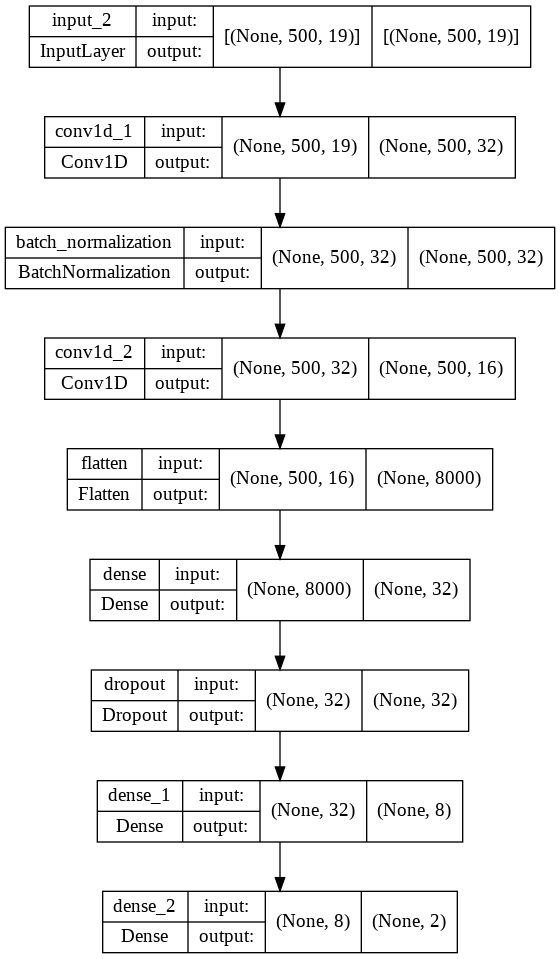

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model1, show_shapes=True, expand_nested=True)

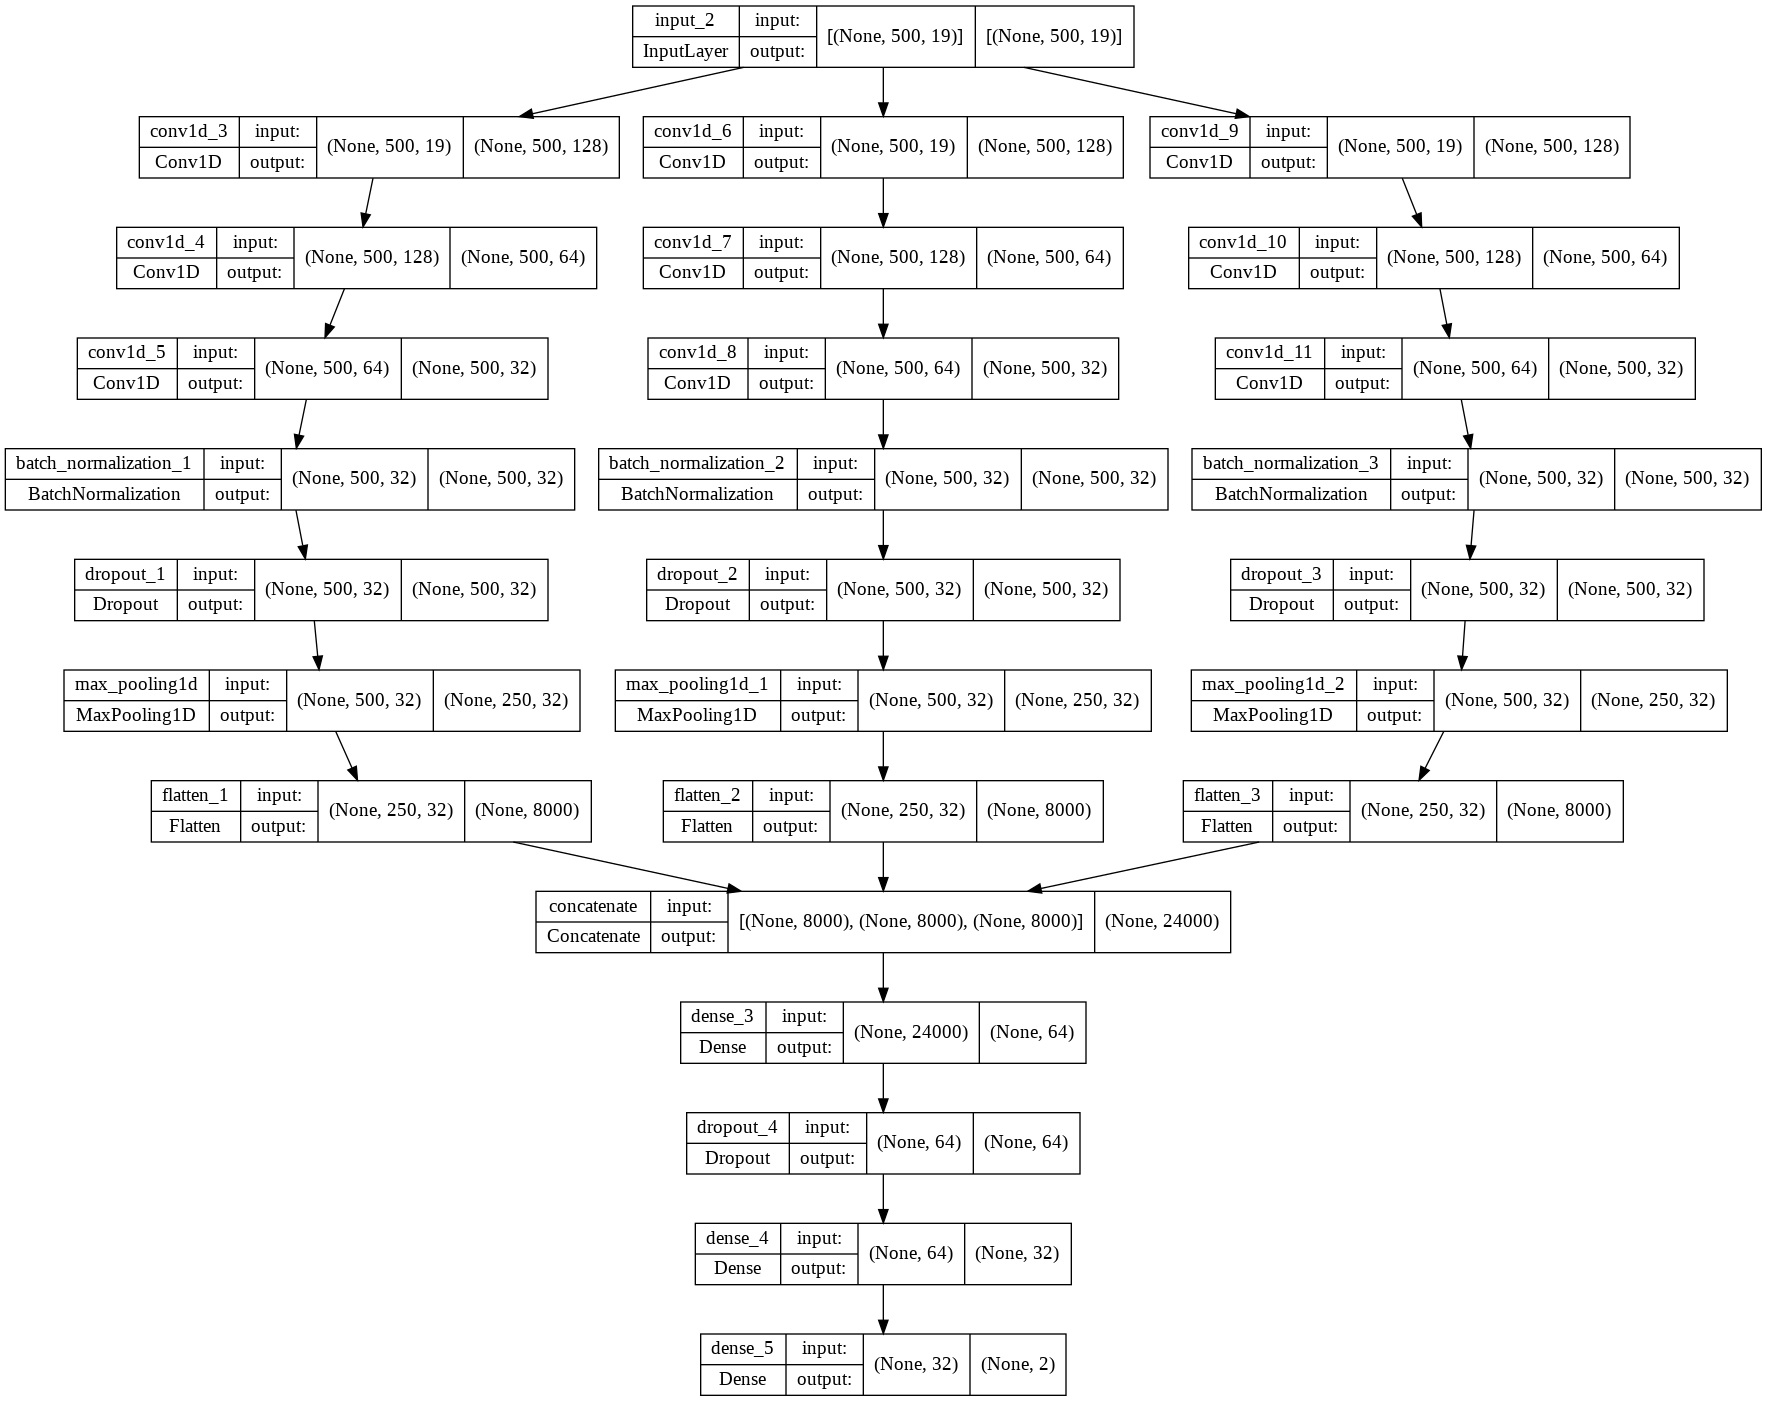

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model2, show_shapes=True, expand_nested=True)

In [ ]:
epocas = 30

In [ ]:
history_m1 = model1.fit(train,validation_data=val, epochs=epocas, callbacks=[tb_m1])

In [ ]:
history_m2 = model2.fit(train,validation_data=val, epochs=epocas, callbacks=[tb_m2])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
fig.suptitle('Modelo 01')

axs[0].plot(history_mlp.history['accuracy'], label='accuracy')
axs[0].plot(history_mlp.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])
axs[0].legend(loc='upper right')

axs[1].plot(history_mlp.history['loss'], label='loss')
axs[1].plot(history_mlp.history['val_loss'], label='val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
fig.suptitle('Modelo 02')

axs[0].plot(history_cnn.history['accuracy'], label='accuracy')
axs[0].plot(history_cnn.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])
axs[0].legend(loc='upper right')

axs[1].plot(history_cnn.history['loss'], label='loss')
axs[1].plot(history_cnn.history['val_loss'], label='val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')